[![Colab Badge](https://img.shields.io/badge/Open_in_Colab-blue?style=for-the-badge)][colab-link]
<a href="javascript:void(0);" onclick="openJupyterWidget('https://github.com/nmfs-opensci/nmfshackdays-2025/blob/main/topics-2025/2025-02-14-earthdata/4-data-cubes.ipynb');">
    <img src="https://img.shields.io/badge/Open_in_JupyterHub-orange?style=for-the-badge" alt="JupyterHub Badge">
</a> [![Download Badge](https://img.shields.io/badge/Download-grey?style=for-the-badge)][download-link]

[download-link]: https://nmfs-opensci.github.io/NMFSHackDays-2025/topics-2025/2025-02-14-earthdata/4-data-cubes.ipynb
[colab-link]: https://colab.research.google.com/github/nmfs-opensci/nmfshackdays-2025/blob/main/topics-2025/2025-02-14-earthdata/4-data-cubes.ipynb
[jupyter-link]: https://nmfs-openscapes.2i2c.cloud/hub/user-redirect/lab?fromURL=https://raw.githubusercontent.com/nmfs-opensci/nmfshackdays-2025/main/topics-2025/2025-02-14-earthdata/4-data-cubes.ipynb

>📘 Learning Objectives
>
> 1. Intro to some `xarray` tools for data cubes
> 2. Point you to resources on line

## Summary

Once we have an `xarray` DataArray, there are many things we can do with it like aggregation, sampling, means and interpolation. See [this tutorial](https://earth-env-data-science.github.io/lectures/xarray/xarray-part2.html) for examples. See the `xarray` [gallery](https://docs.xarray.dev/en/latest/gallery.html) in the documentation.

We will use the [GHRSST Level 4 AVHRR_OI Global Blended Sea Surface Temperature Analysis](https://cmr.earthdata.nasa.gov/search/concepts/C2036881712-POCLOUD.html) data from NCEI. It is lower resolution than the MUR data and will load faster. Also keep in mind that we are on a JupyterHub on Azure while the NASA data is on AWS us-west-2. This means we have to do data access via `https` and not direct access via `S3` and our data access is much slower.

#### For those not working in the JupyterHub

Create a code cell and run `pip install earthaccess`.

### Import Required Packages

In [1]:
# Suppress warnings
import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')
from pprint import pprint

import earthaccess
import xarray as xr

## Create our data cube

1) Authenticate

In [2]:
auth = earthaccess.login()
# are we authenticated?
if not auth.authenticated:
    # ask for credentials and persist them in a .netrc file
    auth.login(strategy="interactive", persist=True)

2) Get a vector of urls to our nc files

In [3]:
short_name = 'AVHRR_OI-NCEI-L4-GLOB-v2.1'
version = "2.1"
date_range = ("2020-01-02", "2020-12-31")

results = earthaccess.search_data(
    short_name = short_name,
    version = version,
    temporal = date_range,
    cloud_hosted=True
)
len(results)

366

We can look at the data links and see that we will be using `https`.

In [21]:
results[0].data_links()

['https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/AVHRR_OI-NCEI-L4-GLOB-v2.1/20200101120000-NCEI-L4_GHRSST-SSTblend-AVHRR_OI-GLOB-v02.0-fv02.1.nc']

In [12]:
results[0]

Collection: {'Version': '2.1', 'ShortName': 'AVHRR_OI-NCEI-L4-GLOB-v2.1'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'WestBoundingCoordinate': -179.875, 'SouthBoundingCoordinate': -89.875, 'EastBoundingCoordinate': 179.875, 'NorthBoundingCoordinate': 89.875}]}}}
Temporal coverage: {'RangeDateTime': {'EndingDateTime': '2020-01-02T00:00:00.000Z', 'BeginningDateTime': '2020-01-01T00:00:00.000Z'}}
Size(MB): 0.9942235946655273
Data: ['https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/AVHRR_OI-NCEI-L4-GLOB-v2.1/20200101120000-NCEI-L4_GHRSST-SSTblend-AVHRR_OI-GLOB-v02.0-fv02.1.nc']

In [4]:
fileset = earthaccess.open(results)
ds = xr.open_dataset(fileset[0])

QUEUEING TASKS | :   0%|          | 0/366 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/366 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/366 [00:00<?, ?it/s]

3) Create our data cube and save

This will take a few minutes to run. But to speed things up, I have uploaded `littlecube.nc` to the website.

4) Load our data cube

In [6]:
url = "https://nmfs-opensci.github.io/NMFSHackDays-2025/topics-2025/2025-02-14-earthdata/littlecube.nc#mode=bytes"
dc = xr.open_dataset(url)['analysed_sst']
dc

<xarray.DataArray 'analysed_sst' (time: 366, lat: 8, lon: 8)> Size: 94kB
[23424 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 3kB 2020-01-01 2020-01-02 ... 2020-12-31
  * lat      (lat) float32 32B 33.62 33.88 34.12 34.38 34.62 34.88 35.12 35.38
  * lon      (lon) float32 32B -75.38 -75.12 -74.88 ... -74.12 -73.88 -73.62
Attributes:
    long_name:      analysed sea surface temperature
    standard_name:  sea_surface_temperature
    units:          kelvin
    valid_min:      -300
    valid_max:      4500
    source:         UNKNOWN,ICOADS SHIPS,ICOADS BUOYS,ICOADS argos,MMAB_50KM-...
    comment:        Single-sensor Pathfinder 5.0/5.1 AVHRR SSTs used until 20...

## Means

Overall mean, all the data.

In [6]:
dc.mean()

<xarray.DataArray 'analysed_sst' ()> Size: 4B
array(298.5631, dtype=float32)

Daily means over all space.

In [7]:
dc.mean(dim=['lat', 'lon'])

<xarray.DataArray 'analysed_sst' (time: 366)> Size: 1kB
array([296.73938, 296.89343, 296.92328, 296.5633 , 296.70032, 296.6867 ,
       296.5006 , 296.46686, 296.1819 , 296.1514 , 296.5408 , 296.08966,
       295.66736, 296.16452, 295.9995 , 295.877  , 295.8689 , 295.81546,
       295.4739 , 295.47705, 295.5378 , 295.7533 , 296.26517, 296.2378 ,
       296.21436, 296.1822 , 295.98047, 295.8164 , 295.77423, 295.4317 ,
       295.04297, 294.88858, 295.22015, 295.47452, 295.70532, 295.77185,
       295.7725 , 295.91983, 295.9339 , 295.44202, 295.20624, 295.39514,
       295.65704, 295.5511 , 295.38702, 295.16672, 295.48843, 295.60126,
       295.6162 , 295.88547, 295.90265, 295.3266 , 294.7489 , 294.76062,
       295.0053 , 295.41937, 295.71063, 295.4889 , 295.3653 , 295.50092,
       295.05002, 295.18872, 296.33875, 296.76828, 296.80655, 296.55017,
       297.15778, 296.6717 , 296.58655, 296.70078, 297.09686, 297.0692 ,
       297.34595, 297.4648 , 297.54623, 297.45624, 297.36905, 297.41486,
       297.29703, 296.94843, 297.00296, 297.10297, 297.04312, 296.8697 ,
       296.79578, 296.73407, 296.51404, 296.18063, 296.0562 , 296.51172,
       297.10498, 296.7483 , 296.03015, 295.92047, 295.88983, 296.16718,
       296.38904, 296.59125, 296.5714 , 296.40424, 296.64355, 296.26392,
       296.03467, 295.97986, 295.99875, 296.44983, 296.52673, 296.5022 ,
       296.50577, 296.57452, 296.70624, 296.77856, 296.8775 , 296.67688,
       296.6355 , 297.33484, 297.4214 , 298.06763, 298.31906, 298.20358,
...
       302.57956, 302.55872, 302.62   , 302.58328, 302.49185, 302.51434,
       302.33905, 302.04706, 301.8042 , 301.58594, 301.35706, 301.13138,
       300.88452, 300.43124, 300.33765, 300.18933, 300.16235, 300.14844,
       300.14154, 300.1325 , 300.32718, 300.47137, 300.50735, 300.43372,
       300.39575, 300.45062, 300.4033 , 300.4425 , 300.3039 , 300.35266,
       300.3156 , 300.26   , 300.0495 , 300.2542 , 300.35547, 300.2417 ,
       299.96796, 299.90717, 299.70624, 299.72375, 299.85138, 299.90015,
       299.88782, 300.08936, 300.11   , 300.11578, 300.1589 , 299.89825,
       299.90952, 299.89752, 299.88358, 299.8698 , 299.54364, 299.56876,
       299.3811 , 299.2125 , 298.97998, 298.70248, 298.53064, 298.51123,
       298.48468, 298.60687, 298.55936, 298.48657, 298.63562, 298.5814 ,
       298.34875, 298.12827, 298.09656, 298.14514, 298.11514, 297.3639 ,
       297.1286 , 297.10577, 297.1211 , 297.15747, 296.96002, 297.01843,
       297.25876, 297.4072 , 297.40875, 297.13153, 297.27155, 297.52905,
       297.53876, 296.89252, 296.70795, 296.85562, 296.985  , 297.0583 ,
       296.807  , 296.40845, 296.39642, 296.32092, 296.14795, 296.52753,
       296.67593, 296.8983 , 296.97797, 297.04175, 296.1742 , 296.05078,
       295.62952, 295.8086 , 295.93842, 295.68674, 295.57547, 295.6925 ,
       295.84045, 295.65625, 295.6156 , 295.69235, 295.31842, 295.1786 ],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 3kB 2020-01-01 2020-01-02 ... 2020-12-31

Mean over all days.

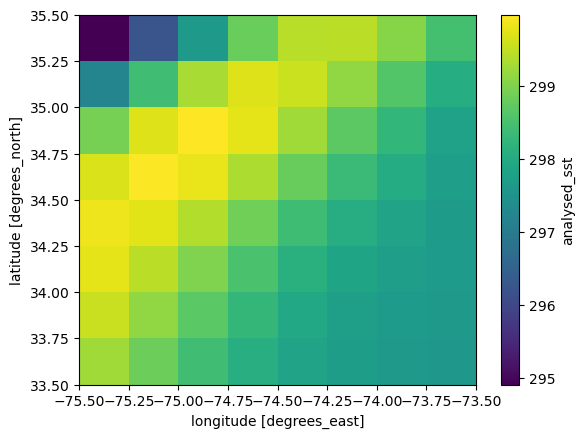

In [9]:
dc.mean(dim=['time']).plot()

## Grouped Means

Monthly, seasonal means, or custom. `xarray` is designed help you do typical climate calculations. See [this tutorial](https://earth-env-data-science.github.io/lectures/xarray/xarray-part2.html) for examples. See the `xarray` [gallery](https://docs.xarray.dev/en/latest/gallery.html) in the documentation. This [tutorial](https://docs.xarray.dev/en/latest/examples/monthly-means.html) shows means with weighting.

### Monthly

In [10]:
dc_monthly = dc.resample(time='1MS').mean()
dc_monthly

<xarray.DataArray 'analysed_sst' (time: 12, lat: 8, lon: 8)> Size: 3kB
array([[[296.9161 , 296.48288, 296.22327, 296.16   , 296.1964 ,
         296.07352, 295.80743, 295.47256],
        [297.16415, 296.80353, 296.51355, 296.3316 , 296.1929 ,
         295.99835, 295.6813 , 295.29578],
        [297.13968, 296.93286, 296.70193, 296.48032, 296.27744,
         296.00903, 295.58774, 295.16193],
        [297.1003 , 297.0984 , 296.9694 , 296.74966, 296.46744,
         296.12775, 295.62775, 295.13354],
        [297.02063, 297.2971 , 297.25   , 297.01392, 296.66196,
         296.22934, 295.68643, 295.11255],
        [296.29773, 297.15997, 297.34677, 297.15097, 296.76773,
         296.30838, 295.80222, 295.21222],
        [293.87357, 295.5761 , 296.5371 , 296.86255, 296.6787 ,
         296.34323, 295.90228, 295.32126],
        [290.24966, 292.47968, 294.4603 , 295.85062, 296.49615,
         296.558  , 296.20642, 295.63776]],

       [[296.3341 , 295.47723, 294.7462 , 294.3193 , 294.1693 ,
         294.26376, 294.38898, 294.46448],
        [296.92584, 296.05792, 295.19794, 294.60654, 294.31033,
...
         298.79996, 298.06934, 297.46368],
        [294.257  , 295.36368, 296.789  , 298.23196, 299.116  ,
         299.17365, 298.57928, 297.94464]],

       [[297.47675, 296.9103 , 296.28128, 295.7184 , 295.37866,
         295.26645, 295.30548, 295.4164 ],
        [297.69293, 297.20352, 296.5761 , 295.95096, 295.51385,
         295.31454, 295.24738, 295.26065],
        [297.78708, 297.49353, 296.95062, 296.30417, 295.76486,
         295.4597 , 295.2748 , 295.15585],
        [297.77063, 297.78806, 297.40323, 296.78485, 296.12967,
         295.72324, 295.4055 , 295.14032],
        [297.52805, 297.9558 , 297.86838, 297.3313 , 296.6045 ,
         296.0803 , 295.64093, 295.22516],
        [296.6216 , 297.469  , 297.8261 , 297.66513, 297.12387,
         296.64093, 296.08096, 295.49902],
        [294.5638 , 295.72772, 296.73032, 297.3248 , 297.4303 ,
         297.3384 , 296.77286, 296.05383],
        [291.87   , 293.03546, 294.47287, 295.90158, 296.97806,
         297.611  , 297.3674 , 296.68582]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 32B 33.62 33.88 34.12 34.38 34.62 34.88 35.12 35.38
  * lon      (lon) float32 32B -75.38 -75.12 -74.88 ... -74.12 -73.88 -73.62
  * time     (time) datetime64[ns] 96B 2020-01-01 2020-02-01 ... 2020-12-01
Attributes:
    long_name:      analysed sea surface temperature
    standard_name:  sea_surface_temperature
    units:          kelvin
    valid_min:      -300
    valid_max:      4500
    source:         UNKNOWN,ICOADS SHIPS,ICOADS BUOYS,ICOADS argos,MMAB_50KM-...
    comment:        Single-sensor Pathfinder 5.0/5.1 AVHRR SSTs used until 20...

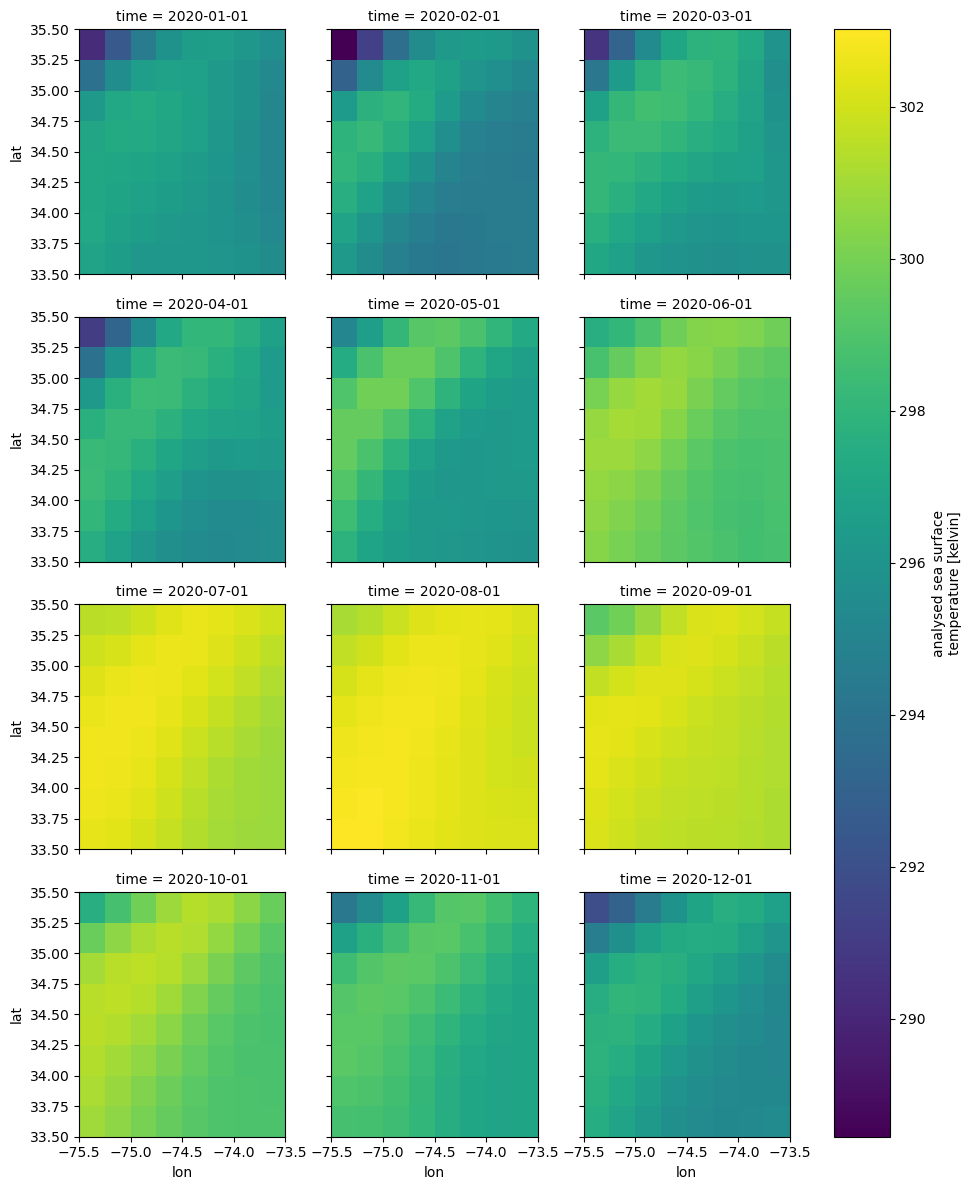

In [11]:
dc_monthly.plot(x='lon', y='lat', col="time", col_wrap=3);

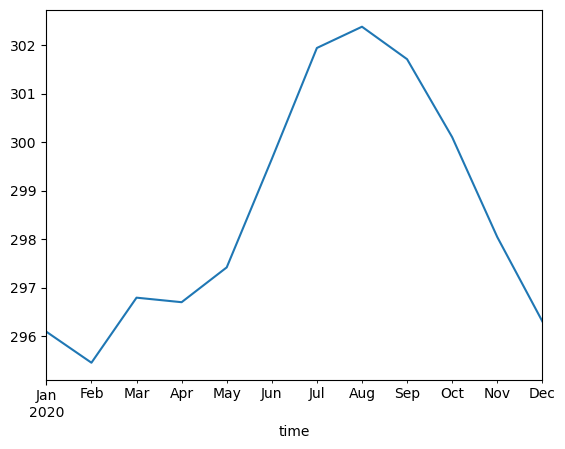

In [12]:
dc_monthly.mean(dim=['lat', 'lon']).to_pandas().plot();

### Seasonal (quarterly)

<Axes: xlabel='time'>

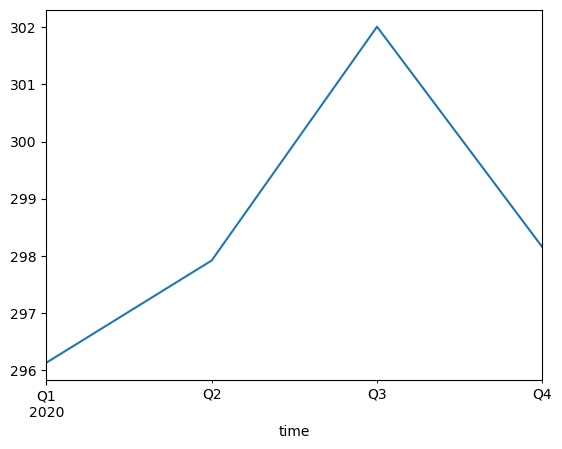

In [13]:
dc_qtr = dc.resample(time='Q').mean()
dc_qtr.mean(dim=['lat', 'lon']).to_pandas().plot()

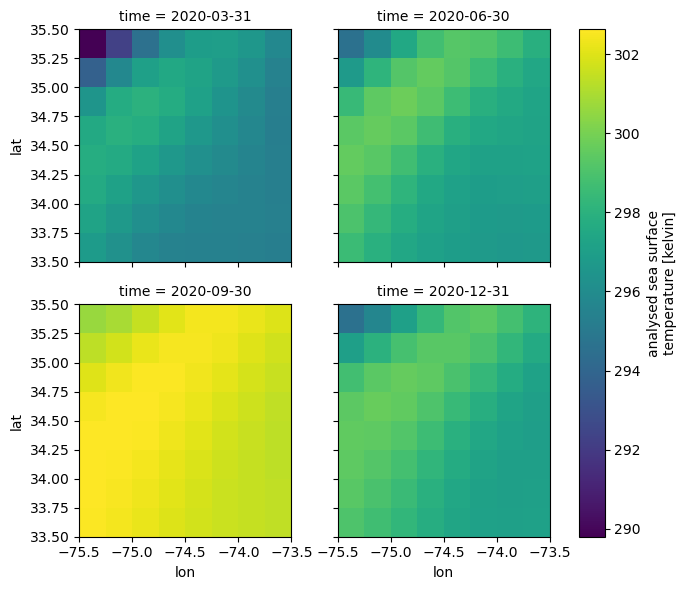

In [72]:
dc_qtr.plot(x='lon', y='lat', col="time", col_wrap=2);

## Summary

We learned how to do some simple spatial and temporal means with `xarray` data cubes.

## References

* [An Introduction to Earth and Environmental Data Science](https://earth-env-data-science.github.io)
* [xarray user guide](https://docs.xarray.dev/en/stable/user-guide/index.html)